Install packages

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import scipy
from scipy.stats import boxcox, boxcox_normmax
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from typing import List
from sklearn import linear_model
from collections import Counter, defaultdict
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from cycler import cycler
from module.preprocess_eda import *
py.init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

Import data

In [12]:
df_train = pd.read_csv('./input/house_price/train.csv')


In [13]:
unmeaninfulNA = ['MiscVal']
meaningfulNA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
preprocessed_data = preprocess_null_values(df_train, unmeaninfulNA, meaningfulNA, 'No')



In [14]:
int_columns = select_column_names_with_types(preprocessed_data, ['int'])
float_columns = select_column_names_with_types(preprocessed_data, ['float'])
object_columns = select_column_names_with_types(preprocessed_data, ['object'])

Step1. Find Null Varialbes

In [15]:
null_data = count_null_nonnull_variables_in_columns(preprocessed_data, 'Exist', 'Null')



In [16]:
graph_nonnull = set_graph_null_nonnull_values_in_columns(
    null_data, 'Exist', 'rgba(246, 78, 139, 0.6)', 'rgba(246, 78, 139, 1.0)', 3
)
graph_null = set_graph_null_nonnull_values_in_columns(
    null_data, 'Null', 'rgba(58, 71, 80, 0.6)', 'rgba(58, 71, 80, 1.0)', 3
)


In [17]:
display_bar_graph([graph_nonnull, graph_null], 'stack', 'Null Value BarPlot')
print('Number of Missing Index Sum (MasVnrType, MasVnrARea, Electrical) : ',
df_train[['MasVnrType', 'MasVnrArea', 'Electrical']].isnull().values.sum())

Number of Missing Index Sum (MasVnrType, MasVnrARea, Electrical) :  17


drop missing values in data based on the columns with the small number of missing values

In [18]:
data_wo_small_missing_values = df_train.loc[df_train[['Electrical', 'MasVnrArea', 'MasVnrType']].isnull().sum(axis=1) == 0, :]


Correlation:
1. Electrical, MasVnrArea, MasVnrType with small number of missing values, which can be dropped out.
2. GarageYrBlt has strong correlation with YearBuild
3. find whether other variables with strong correlation with LotFrontage, if not linear impute null variables
3.1. 1stFlrSF, LotArea are the first and sencond variavles with high correlation of LotFrontage

In [19]:
print(calculate_correlation_two_columns(data_wo_small_missing_values, 'GarageYrBlt', 'YearBuilt'))
print(calculate_max_correlation_one_column_to_multiple_columns(data_wo_small_missing_values, 'LotFrontage'))

0.82
0.46


In [ ]:
def impute_null_variables(data: pd.DataFrame, impute_column: str, refer_column: list) -> array:
    '''
    Use linear imputation to impute null variables
    Return: TODO
    TODO: Not finished
    '''
    data_impute = data.loc[:, refer_column+[impute_column]].copy()
    test_index = data_impute.loc[:, impute_column].isnull()
    train = data_impute.loc[~test_index, :]
    test = data_impute.loc[test_index, :]
    model = linear_model.LinearRegression()
    model.fit(train.loc[:, refer_column], train.loc[:, impute_column])
    result = model.predict(test.loc[:, refer_column])
    return result

1.2. Outlier¶   => TODO


2. Group & SalePrice

<Figure size 432x576 with 0 Axes>

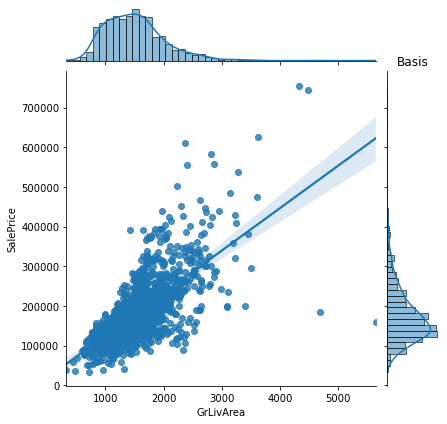

In [45]:

plot_jointplot(
    data=data_wo_small_missing_values,
    column1='GrLivArea',
    column2='SalePrice',
    kind='reg',
    xlabel='GrLvArea',
    ylabel='SalePrice',
    title='Basis'
)


In small GrLivArea may have proportional effects on Saleprice, but if larger may lose effects

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

Mean average squared error: 1401695.21


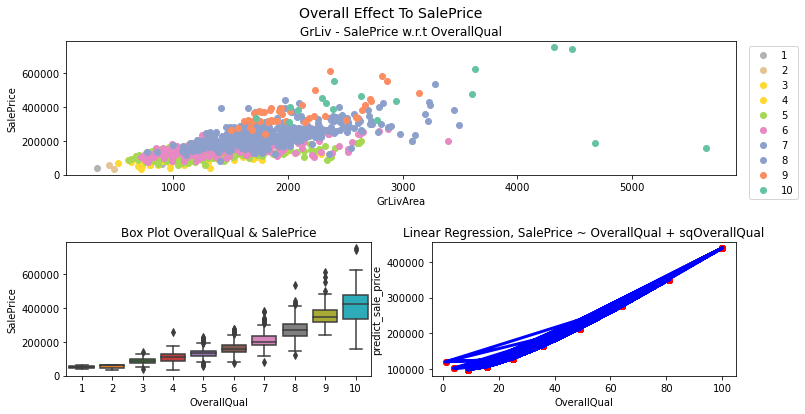

In [89]:
plt.figure(figsize=(12, 6))
plot_settings = plt.subplot2grid((2, 2,), (0, 0), colspan=2)
plot_scatter_on_levels(
    data=data_wo_small_missing_values,
    plot_settings=plot_settings,
    color_number=10,
    levels=range(1, 11),
    xlabel='GrLivArea',
    ylabel='SalePrice',
    title='GrLiv - SalePrice w.r.t OverallQual',
    column_level='OverallQual',
    column_x='GrLivArea',
    column_y='SalePrice'
)
plot_settings2 = plt.subplot2grid((2, 2), (1, 0))
plot_box(
    data=data_wo_small_missing_values,
    column_x='OverallQual',
    column_y='SalePrice',
    plot_settings=plot_settings2,
    title='Box Plot OverallQual & SalePrice'
)
check_distribution = data_wo_small_missing_values.groupby(['OverallQual'])['SalePrice'].mean().round(0)
# find the relationship between two variables may be power
test_data = data_wo_small_missing_values.loc[:, ['OverallQual', 'SalePrice']].copy()
test_data['sqOverallQual'] = np.power(test_data['OverallQual'], 2)
predict_result = predict_linear_model(test_data, ['OverallQual', 'sqOverallQual'], 'SalePrice')

print("Mean average squared error: %.2f" % (mean_squared_error(predict_result, test_data['SalePrice'])/len(test_data)))


plot_settings3 = plt.subplot2grid((2, 2), (1, 1))
plot_multiple_plots(
    data=test_data,
    column_x='sqOverallQual',
    column_y=predict_result,
    plot_settings=plot_settings3,
    multiple=True,
    title='Linear Regression, SalePrice ~ OverallQual + sqOverallQual',
    xlabel='OverallQual',
    ylabel='predict_sale_price'
    )

plt.subplots_adjust(hspace = 0.5, top = 0.9)
plt.suptitle('Overall Effect To SalePrice', fontsize = 14)
plt.show()

In [ ]:
plt.figure(figsize = (12,6))
tf_train = df_train[['OverallQual','2ndFlrSF', 'TotalBsmtSF', 'SalePrice']].copy()
tf_train['GrLivArea'] = df_train['GrLivArea'].copy()
tf_train['2ndFlr'] = 'Exist'
tf_train.loc[tf_train['2ndFlrSF'] == 0 ,'2ndFlr'] = 'Not'
tf_train['Bsmt'] = 'Exist'
tf_train.loc[tf_train['TotalBsmtSF'] == 0 ,'Bsmt'] = 'Not'
ax1 = plt.subplot2grid((2,2), (0,0), colspan = 2)
tmp = tf_train[['2ndFlr', 'Bsmt']].apply(pd.Series.value_counts).T
tmp.plot.barh(stacked = True, ax = ax1)
ax1.set_title('Exsitence or Not of Bsmt and 2ndFlr', fontsize = 12)
ax2 = plt.subplot2grid((2,2), (1,0))
ax2.scatter(tf_train['GrLivArea'].loc[tf_train['2ndFlr'] == 'Exist'], tf_train['SalePrice'].loc[tf_train['2ndFlr'] == 'Exist'], color = 'r', alpha = 1, label = 'Exist')
ax2.scatter(tf_train['GrLivArea'].loc[tf_train['2ndFlr'] != 'Exist'], tf_train['SalePrice'].loc[tf_train['2ndFlr'] != 'Exist'], color = 'b', alpha = 0.5, label = 'Not')
ax2.set_title('2ndFlr Effect on GrLivArea and SalePrice')
ax2.legend(bbox_to_anchor = [1.2, 0.8])

ax3 = plt.subplot2grid((2,2), (1,1))
ax3.scatter(tf_train['GrLivArea'].loc[tf_train['Bsmt'] == 'Exist'], tf_train['SalePrice'].loc[tf_train['Bsmt'] == 'Exist'], color = 'r', alpha = 1)
ax3.scatter(tf_train['GrLivArea'].loc[tf_train['Bsmt'] != 'Exist'], tf_train['SalePrice'].loc[tf_train['Bsmt'] != 'Exist'], color = 'b', alpha = 0.5)
ax3.set_yticks([])
ax3.set_title('Bsmt Effect on GrLivArea and SalePrice')
plt.subplots_adjust(hspace = 0.3, wspace = 0.2)
plt.suptitle('2ndFlr & Basement', fontsize = 14)
plt.show()

2.3. Bath

In [ ]:
bath = ['FullBath','HalfBath']#'BsmtFullBath', 'BsmtHalfBath',
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df_train[bath[0]], df_train[bath[1]]).style.background_gradient(cmap = cm)

In [ ]:
plt.figure(figsize = (12,6))
ax1= plt.subplot2grid((2,2), (0,0), colspan = 2)
#colors = pandas.tools.plotting._get_standard_colors(10, color_type = 'random')
colors = sns.color_palette('Set1_r', 4)
ax1.set_color_cycle(colors)
groups = df_train.groupby(['FullBath', 'HalfBath'])
print('Full Correlation (GrLivArea - SalePrice) % .2f' % np.corrcoef(df_train['GrLivArea'], df_train['SalePrice'])[0][1])
for name, group in groups:
    if name in ((1,0), (1,1), (2,0), (2,1)):
        print(str(name) + 'Correlation %.2f ' % np.corrcoef(group['GrLivArea'], group['SalePrice'])[0][1])
        ax1.plot(group['GrLivArea'], group['SalePrice'], marker = 'o', linestyle = '', label = name, alpha = 0.7)
ax1.legend(loc = 'upper right')
ax1.set_title('Full/HalfBath Categorized Scatter')
ax1.set_xlabel('GrLivArea')
ax1.set_ylabel('SalePrice')

ax2= plt.subplot2grid((2,2), (1,0))
sns.regplot(x = 'GrLivArea', y = 'SalePrice', order = 1,
            data = df_train.loc[(df_train['FullBath'] == 2 ) & (df_train['HalfBath']==1), ['GrLivArea', 'SalePrice']], 
            ax = ax2, line_kws = {'color' : 'red'}, scatter_kws = {'color' : 'blue', 'alpha' : 0.5})
ax2.set_title('Bath(2,1) GrLiv - SalePrice Regression')

ax3= plt.subplot2grid((2,2), (1,1))
testTrain = df_train.loc[:, ['GrLivArea', 'SalePrice']].copy()
testTrain['Bath'] = df_train[['FullBath', 'HalfBath']].sum(axis = 1)
sns.boxplot(x = 'Bath', y = 'SalePrice', order= [1,2,3], data =testTrain, ax =ax3, palette =sns.color_palette('winter_r',3))
ax3.set_title('Sum Bath - SalePrice BoxPlot')
ax3.set_yticks([])
ax3.set_ylabel('')
ax3.set_xlabel('Sum Bath')

plt.subplots_adjust(0,0,1, 0.9,hspace = 0.5)
plt.suptitle('Bath Relationship with SalePrice', fontsize = 14, y = 1.05)
plt.show()

In [ ]:
2.4. Techical Room

In [ ]:
plt.figure(figsize = (12,6))
ax = plt.subplot2grid((3,3), (0,0), rowspan = 2, colspan = 2)
bath = ['BedroomAbvGr', 'TotRmsAbvGrd']#'BsmtFullBath', 'BsmtHalfBath',
test = pd.crosstab(df_train[bath[0]], df_train[bath[1]])
sns.heatmap(test.values, cmap = plt.cm.Reds, ax = ax, linewidths=.5), #yticklabels=False, xticklabels=False)
ax.set_ylabel('TotRooms Number')
ax.set_xlabel('Bedroom Num')
ax.set_title('TotRomm - Bedroom Num')


ax2 = plt.subplot2grid((3,3), (0,2))
colors = sns.color_palette('Set2',3)
pack = [3,4,5]
val = pack[0]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.TotRmsAbvGrd == val], 
            scatter_kws = {'color' : colors[val-3], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax2)
#ax2.set_yticklabels([])
ax2.set_title('TotRmsAbvGrd 3 - (GrLiv:SalePrice)', fontsize = 9)
ax2.set_ylabel('')
ax2.set_xlabel('Correlation ' + str(df_train.loc[df_train.TotRmsAbvGrd == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

ax3 = plt.subplot2grid((3,3), (1,2))
val = pack[1]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.TotRmsAbvGrd == val], 
            scatter_kws = {'color' : 'pink', 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax3)
#ax3.set_yticklabels([])
ax3.set_ylabel('')
ax3.set_title('TotRmsAbvGrd 4 - (GrLiv:SalePrice)' , fontsize = 9)
ax3.set_xlabel('Correlation ' + str(df_train.loc[df_train.TotRmsAbvGrd == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))
ax3.legend()

ax4 = plt.subplot2grid((3,3), (2,2))
val = pack[2]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.TotRmsAbvGrd == val], 
            scatter_kws = {'color' : colors[val-3], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax4)
#ax4.set_yticklabels([])
ax4.set_title('TotRmsAbvGrd 5 - (GrLiv:SalePrice)' , fontsize = 9)
ax4.set_ylabel('')
ax4.set_xlabel('Correlation ' + str(df_train.loc[df_train.TotRmsAbvGrd == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

pack = [1,6]

ax5 = plt.subplot2grid((3,3), (2,0))
val = pack[0]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.BedroomAbvGr == val], 
            scatter_kws = {'color' : colors[0], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax5)
#ax4.set_yticklabels([])
ax5.set_title('BedroomAbvGrd 1 - (GrLiv:SalePrice)' , fontsize = 9)
ax5.set_ylabel('')
ax5.set_xlabel('Correlation ' + str(df_train.loc[df_train.BedroomAbvGr == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))

ax6 = plt.subplot2grid((3,3), (2,1))
val = pack[1]
sns.regplot(x='GrLivArea', y = 'SalePrice', data = df_train.loc[df_train.BedroomAbvGr == val], 
            scatter_kws = {'color' : colors[1], 'alpha' : 0.5}, line_kws = {'color' : 'k'}, ax = ax6)
#ax4.set_yticklabels([])
ax6.set_title('BedroomAbvGrd 5 - (GrLiv:SalePrice)' , fontsize = 9)
ax6.set_ylabel('')
ax6.set_xlabel('Correlation ' + str(df_train.loc[df_train.BedroomAbvGr == val, ['GrLivArea', 'SalePrice']].corr().round(2).loc['GrLivArea','SalePrice']))


sns.despine(left = True)


plt.subplots_adjust(top = 0.8, hspace = 1)
plt.suptitle("Room's Usage with SalePrice", fontsize = 14)
plt.show()

2.5. Garage

In [ ]:
garage = ['GarageCars', 'GarageArea']
plt.figure(figsize = (12,6))
ax2 = plt.subplot2grid((2,3), (1,0))
palette = sns.color_palette('Set1',5)
sns.countplot(df_train['GarageCars'], ax = ax2, palette = palette)
ax2.set_title('Number of Occurences of GarageCars')

ax3 = plt.subplot2grid((2,3), (0,0), colspan = 3)
ax3.set_color_cycle(palette)
for val in range(5):
    indexV = df_train.GarageCars == val
    ax3.plot(df_train['GarageArea'].loc[indexV], df_train['SalePrice'].loc[indexV], marker = 'o', linestyle = '', label = val, alpha = 0.7)
ax3.set_xlabel('GarageArea')
ax3.set_ylabel('SalePrice')
ax3.set_title('Scatter x: GarageArea, y : SalePrice')
ax3.set_yticklabels([])
ax3.legend()

ax = plt.subplot2grid((2,3), (1,2))
num = [0,1,2,3]
ax.set_color_cycle(sns.color_palette('Set2', 4))
for val in num:
    index = df_train.GarageCars == val
    ax.scatter(df_train.GrLivArea.loc[index], df_train.GarageArea.loc[index], label = val, alpha = 0.5)
ax.set_xlabel('GrLivArea')
ax.set_ylabel('GarageArea')
ax.set_title('Scatter x: GrLivArea, y : GarageArea')
ax.legend()

def functions(x):
    if x['GarageCars'] == 0: return 0
    else:
        return x['GarageArea']/ x['GarageCars']
unitCarArea = df_train.apply(functions, axis = 1)

ax3= plt.subplot2grid((2,3), (1,1))
ax3.set_color_cycle(palette)
for val in range(4):
    indexV = df_train.GarageCars == val
    ax3.plot(unitCarArea.loc[indexV], df_train['SalePrice'].loc[indexV], marker = 'o', linestyle = '', label = val, alpha = 0.7)
ax3.set_xlabel('Unit_GarageArea')
ax3.set_ylabel('SalePrice')
ax3.set_title('Unit CarArea Effect')
ax3.set_yticklabels([])
ax3.legend()

sns.despine(left = True)
plt.subplots_adjust(wspace = 0.3, hspace = 0.5, top =0.8)
plt.suptitle('Garage-SalePrice', fontsize = 14)
plt.show()
#df_train.GarageCars.loc[df_train.GarageCars == 4] = 3